In [1]:
import os

In [2]:
from torch.utils.data import DataLoader

In [3]:
import torchvision.transforms as T

In [4]:
from torchvision.datasets import ImageFolder

In [5]:
data_dir='C:/Users/Admin/celebrity_data'

In [6]:
image_size=65

batch_size=256

stats=(0.5,0.5,0.5),(0.5,0.5,0.5)


In [7]:
train_ds=ImageFolder(data_dir,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl=DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=2)

In [8]:
import torch

In [9]:
from torchvision.utils import make_grid

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
#def denorm(image_tensors):
   # return image_tensors * stats[0][1] + stats [0][0]

In [12]:
def denorm(x):
    return (x + 1) / 2


In [13]:
def show_images(images,nmax=65):
    fig,ax=plt.subplots(figsize=(10,10))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=65):
    for images,_ in dl:
        show_images(images,nmax)
        break

C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


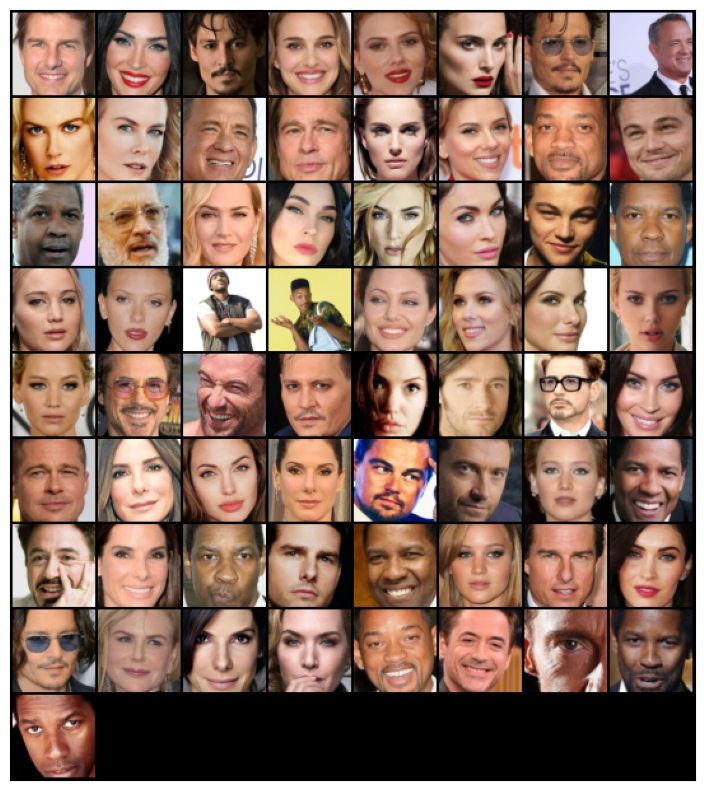

In [14]:
show_batch(train_dl)

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]

        return data.to(device,non_blocking=True)
        

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def _init_(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)


            def __len__(self):
                return len(self.dl)


In [17]:
class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)


In [18]:
device=get_default_device()
device

device(type='cpu')

In [19]:
train_dl=DeviceDataLoader(train_dl,  device)

In [20]:
import torch.nn as nn

In [21]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 65, kernel_size=3, stride=3, padding=1, bias=True),
    nn.BatchNorm2d(65),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(65, 128, kernel_size=3, stride=3, padding=1, bias=True),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=1, bias=True),  # ✅ fixed input channels
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=3, stride=3, padding=1, bias=True),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=3, stride=3, padding=1, bias=True),

    nn.Flatten(),
    nn.Sigmoid()
)


In [22]:
#descriminator=to_device(descriminator,device)

In [23]:
discriminator = to_device(discriminator, device)


In [24]:
latent_size=128

In [25]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, bias=False),
    nn.Tanh()
)


In [26]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    # Real image predictions
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Fake image generation with correct latent shape
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Fake image predictions
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Total loss and optimization
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()

    return loss.item(), real_score, fake_score


In [27]:
generator=to_device(generator,device)

In [28]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)

    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    opt_g.step()

    return loss.item()


In [29]:
from torchvision.utils import save_image

In [30]:
sample_dir='generated'

os.makedirs(sample_dir,exist_ok=True)



In [37]:
def save_samples(index, latent_tensors, show=True):
   # with torch.no_grad():
        fake_images = generator(latent_tensors)
        fake_images = denorm(fake_images)

        print("Fake image shape:", fake_images.shape)
        print("Fake image dtype:", fake_images.dtype)

        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        print('Saving', fake_fname)

        import matplotlib.pyplot as plt
        %matplotlib inline

        if show:
            fig,ax=plt.subplots(figsize=(10,5))
            ax.set_xticks([]);ax.set_yticks([])
            ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))
            #show_image(fake_images[0])


Fake image shape: torch.Size([65, 3, 1, 1])
Fake image dtype: torch.float32
Saving generated-images-0000.png


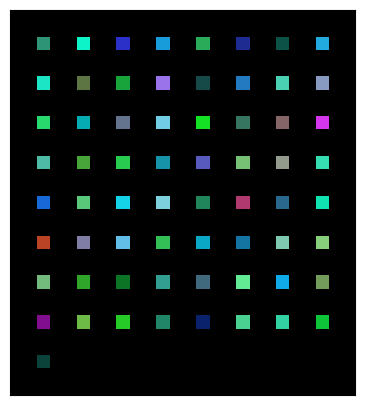

In [38]:
fixed_latent = torch.randn(65, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)


In [42]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device)


In [43]:
#save_samples(0,fixed_latent)
#nn.ConvTranspose2d(64, 3, kernel_size=7, stride=2, padding=1, bias=False)


In [44]:
print(fixed_latent.shape)

torch.Size([64, 128, 1, 1])


In [80]:
#the above image is fakeimage descriminator can identify the real or fake and generator generates the fake images

In [37]:
from tqdm.notebook import tqdm

import torch.nn.functional as F

In [38]:
#fit(discriminator, generator, opt_d, opt_g, train_dl, epochs, lr, fixed_latent)


In [39]:
def fit(discriminator, generator, train_dl, epochs, lr, fixed_latent, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    discriminator = to_device(discriminator, device)
    generator = to_device(generator, device)

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    train_dl = DeviceDataLoader(train_dl, device)

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            real_images = real_images.to(device)

            loss_d, real_score_val, fake_score_val = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score_val)
            fake_scores.append(fake_score_val)

        print("Epoch: [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score_val, fake_score_val))

        save_samples(start_idx + epoch, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [40]:
def denorm(x):
    return (x + 1) / 2


In [41]:
#with torch.no_grad():
    #test_latent = torch.randn(1, latent_size, 1, 1, device=device)
    #test_output = generator(test_latent)
    #print("Output shape:", test_output.shape)
   # print("Output dtype:", test_output.dtype)


In [48]:
%%time
lr=0.005
epochs=3
fixed_latent = torch.randn(65, latent_size, 1, 1, device=device)
#train_dl=DeviceDataLoader(discriminator,device)
train_dl=DataLoader(train_ds,batch_size,shuffle=True,pin_memory=True,num_workers=2)
#train_dl = DataLoader(dataset, batch_size=64, shuffle=True)
train_dl = DeviceDataLoader(train_dl, device)

#history=fit(epochs,lr,train_dl,fixed_latent)
history = fit(discriminator, generator, train_dl, epochs, lr, fixed_latent)
print("train_dl type:", type(train_dl))






  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: [1/3], loss_g: 2.1048, loss_d: 0.5783, real_score: 0.6703, fake_score: 0.1522
Fake image shape: torch.Size([65, 3, 1, 1])
Fake image dtype: torch.float32
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: [2/3], loss_g: 2.1223, loss_d: 4.2012, real_score: 0.5561, fake_score: 0.0878
Fake image shape: torch.Size([65, 3, 1, 1])
Fake image dtype: torch.float32
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: [3/3], loss_g: 2.2324, loss_d: 1.0236, real_score: 0.5011, fake_score: 0.0995
Fake image shape: torch.Size([65, 3, 1, 1])
Fake image dtype: torch.float32
Saving generated-images-0003.png
train_dl type: <class '__main__.DeviceDataLoader'>
CPU times: total: 1min 16s
Wall time: 1min 9s


In [44]:
losses_g,losses_d,real_scores,fake_scores=history


In [45]:
torch.save(generator.state_dict(),'G.pth')


torch.save(discriminator.state_dict(),'D.pth')

In [46]:
from IPython.display import Image

In [56]:
#Image('./generated/generated-images-0001.png',width=256,height=256)

from IPython.display import Image

# Display with custom size
Image('./generated/generated-images-0001.png', width=300, height=256)


In [67]:
Image('./generated/generated-images-0025.png', width=300, height=256)

In [68]:
img_path = './generated/generated-images-0300.png'
if os.path.exists(img_path):
    display(Image(filename=img_path))
else:
    print(f"Image not found: {img_path}")


Image not found: ./generated/generated-images-0300.png


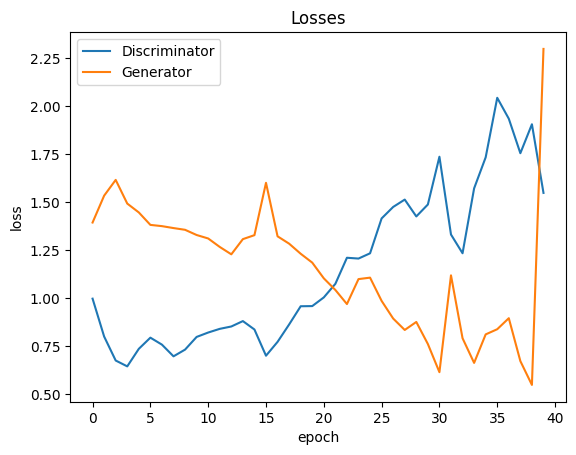

In [71]:
plt.plot(losses_g,'-')
plt.plot(losses_d,'-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator','Generator'])
plt.title('Losses');

C:\Users\Admin\AppData\Local\Temp\ipykernel_8680\2352502188.py:5: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(['Real'],['Fake'])


Text(0.5, 1.0, 'Scores')

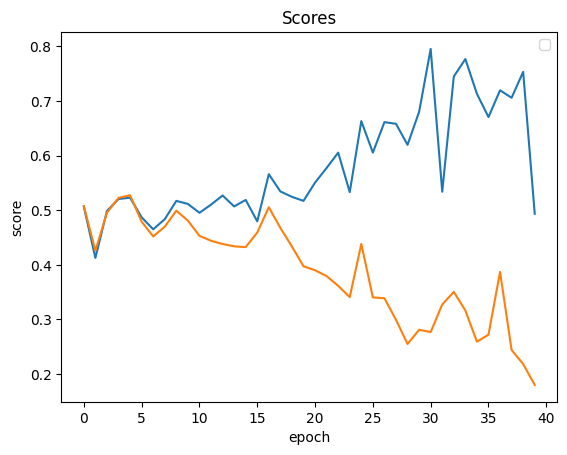

In [74]:
plt.plot(real_scores,'-')
plt.plot(fake_scores,'-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real'],['Fake'])
plt.title('Scores')

In [45]:
print('fine done')

fine done
